In [1]:
import user_tweet_classifier as utc
import user_sentiment_analysis as usa

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Sentiment Analysis

In [3]:
df = usa.preprocess_data(labels_file='data/labels.csv',
                         tweets_file='data/cleaned_tweets.csv',
                         output_file='data/labels_sentiment.csv')
df.head()

,user_id,label,subjectivity,sentiment,binary_strong_negation,binary_excessive_marks,binary_topic_diversity
0,8436472,b,1,1,-1,1,-1
1,1310040047421403136,t,1,-1,-1,1,-1
2,210165301,t,1,-1,-1,-1,-1
3,1220517169961820160,t,-1,-1,-1,-1,-1
4,21906070,b,-1,-1,-1,-1,-1


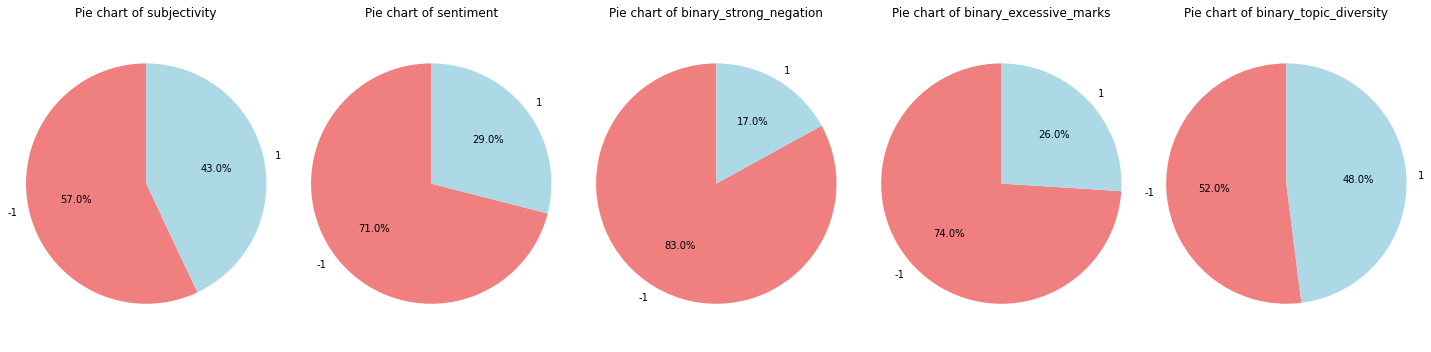

In [4]:
fig, axs = plt.subplots(1, len(df.columns[2:]), figsize=(20, 5))
colors = {-1: 'lightcoral', 1: 'lightblue'}
for i, column in enumerate(df.columns[2:]):
    counts = df[column].value_counts()
    axs[i].pie(counts, labels=counts.index, colors=[colors[val] for val in counts.index], autopct='%1.1f%%', startangle=90)
    axs[i].axis('equal')
    axs[i].set_title(f'Pie chart of {column}')
plt.tight_layout()
plt.show()

# Data Cluster

In [5]:
labels_file = 'data/labels_sentiment.csv'
tweets_file = 'data/cleaned_tweets.csv'

merged_df = utc.load_and_merge_data(labels_file, tweets_file)
label_columns = [
    'label',
    'subjectivity',
    'sentiment',
    'binary_strong_negation',
    'binary_excessive_marks',
    'binary_topic_diversity',
    ]
(merged_df, encoders) = utc.convert_labels(merged_df, label_columns)

In [6]:
(X_train, X_test, Y_train, Y_test) = utc.split_dataset(merged_df)
(X_train_tfidf, X_test_tfidf, trained_vectorizer) = utc.vectorize_text(X_train, X_test)
(X_train_reduced, X_test_reduced, trained_svd) = utc.reduce_dimensions(X_train_tfidf, X_test_tfidf)
(trained_model, Y_pred) = utc.train_and_predict(X_train_reduced, Y_train, X_test_reduced)
utc.evaluate_predictions(Y_test, Y_pred)

Label: label
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        15
           1       1.00      0.20      0.33         5

    accuracy                           0.80        20
   macro avg       0.89      0.60      0.61        20
weighted avg       0.84      0.80      0.75        20

Accuracy: 0.8


In [7]:
predicted_new_data = utc.predict_new_data(tweets_file,trained_vectorizer, trained_svd, trained_model, label_columns)
predicted_new_data = predicted_new_data[[
    'user_id',
    'cleaned_tweets',
    'label',
    'subjectivity',
    'sentiment',
    'binary_strong_negation',
    'binary_excessive_marks',
    'binary_topic_diversity',
    ]]
# predicted_new_data['label'] = predicted_new_data['label'].replace({0: 'Biden', 1: 'Trump'})
display(predicted_new_data.head())

,user_id,cleaned_tweets,label,subjectivity,sentiment,binary_strong_negation,binary_excessive_marks,binary_topic_diversity
0,3.606665e+08,Elecciones2020 | En Florida: JoeBiden dice q...,0,0,0,0,0,0
1,8.436472e+06,"Trump: As a student I used to hear for years, ...",0,0,0,0,0,1
2,8.283556e+17,2 hours since last tweet from Trump! Maybe he...,0,0,0,0,0,0
3,4.741380e+07,You get a tie! And you get a tie! Trump ‘s ra...,0,0,0,0,0,0
4,1.138416e+09,CLady62 Her 15 minutes were over long time ago...,0,0,0,0,0,0


# Learning tweets

In [8]:
predicted_new_data.head()

,user_id,cleaned_tweets,label,subjectivity,sentiment,binary_strong_negation,binary_excessive_marks,binary_topic_diversity
0,3.606665e+08,Elecciones2020 | En Florida: JoeBiden dice q...,0,0,0,0,0,0
1,8.436472e+06,"Trump: As a student I used to hear for years, ...",0,0,0,0,0,1
2,8.283556e+17,2 hours since last tweet from Trump! Maybe he...,0,0,0,0,0,0
3,4.741380e+07,You get a tie! And you get a tie! Trump ‘s ra...,0,0,0,0,0,0
4,1.138416e+09,CLady62 Her 15 minutes were over long time ago...,0,0,0,0,0,0


In [9]:
predict_df = predicted_new_data[['user_id','label','cleaned_tweets']]
predict_df['year'] = 2020
predict_df = predict_df.rename(columns={'cleaned_tweets':'tweet'})
predict_df = predict_df[predict_df['user_id'].notna()]
predict_df['user_id'] = predict_df['user_id'].astype(int)
predict_df.head()

,user_id,label,tweet,year
0,360666534,0,Elecciones2020 | En Florida: JoeBiden dice q...,2020
1,8436472,0,"Trump: As a student I used to hear for years, ...",2020
2,828355589206056960,0,2 hours since last tweet from Trump! Maybe he...,2020
3,47413798,0,You get a tie! And you get a tie! Trump ‘s ra...,2020
4,1138416104,0,CLady62 Her 15 minutes were over long time ago...,2020


In [10]:
# question = 'In 2020, Biden runs for President on the Democratic ticket against Trump for the Republicans. Will you voted for Donald Trump?'
# predict_df = predicted_new_data[['user_id','label']].groupby('user_id',sort=False).median().reset_index()
# predict_df['year'] = 2020
# predict_df['question'] = question
# predict_df = predict_df[['user_id','label','question','year']]
# predict_df = predict_df[predict_df['user_id'].notna()]
# predict_df['user_id'] = predict_df['user_id'].astype(int)
# predict_df.head()

In [11]:
parquet_file = 'data/labels.parquet'
predict_df.to_parquet(parquet_file)